In [1]:
import os
os.chdir("../")
print("Moved up")

Moved up


In [2]:
import importlib
# import refactor.lib_data as lib_data
# import refactor.utils as utils
# import refactor.modules as modules
import lib_data
import utils
import modules
import callbacks


2025-02-06 14:29:19.491466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738852159.506242 2553235 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738852159.510755 2553235 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:00<00:00, 12.5MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 382kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 3.46MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 1.19MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

class labels: [5 0 4 1 9 2 1 3 1 4]


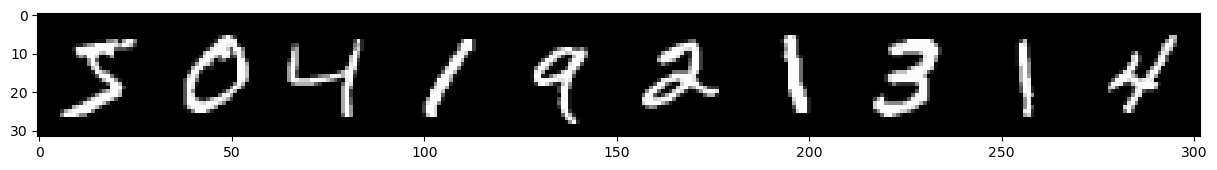

3


In [4]:
importlib.reload(lib_data)
datasets = lib_data.get_mnist(flatten=False, tr_indices=5000, te_indices=1000, hess_indices=10,
                            tr_classes=10, te_classes=10, hess_classes=10, visualise=True)
print(len(datasets))

In [5]:
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from flax import linen as nn  # Linen API
import typing as tp

In [6]:
@struct.dataclass
class Metrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')

In [7]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    batch_stats: tp.Any

def create_train_state(module, rng, learning_rate, momentum):
    """Creates an initial `TrainState`."""
    variables = module.init(rng, jnp.ones([1, 28, 28, 1])) # initialize parameters by passing a template image
    params = variables['params']
    batch_stats = variables['batch_stats']
    
    tx = optax.adam(learning_rate, momentum)
    return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx, batch_stats=batch_stats, 
      metrics=Metrics.empty())

In [8]:
import jax
import jax.numpy as jnp  # JAX NumPy

In [9]:

@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    def loss_fn(params):
        logits, updates = state.apply_fn(
            {'params': params, 'batch_stats': state.batch_stats},
            batch[0],
            train=True,
            mutable=['batch_stats'] 
        )
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch[1]
        ).mean()
        return loss, updates  

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True) 
    (loss, updates), grads = grad_fn(state.params)

    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=updates["batch_stats"])
    return state


In [10]:
@jax.jit
def compute_metrics(*, state, batch):
  logits = state.apply_fn({'params': state.params, 'batch_stats':state.batch_stats}, batch[0], train=False)
  loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch[1]).mean()
  metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=batch[1], loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state

In [11]:
init_rng = jax.random.key(0)

In [12]:
learning_rate = 0.01
momentum = 0.9
num_epochs = 3
batch_size = 32

In [13]:

from flax import linen as nn  # Linen API
import typing as tp
importlib.reload(modules)
from functools import partial

class ResNet20(nn.Module):
    """A simple CNN model."""
    resnet_base = 8
    use_DO = False
    use_BN = True
    sc_conv = 'Identity'
    deterministic: tp.Optional[bool] = None
    
    @nn.compact
    def __call__(self, x, train=True):
        deterministic = not train
        deterministic = nn.merge_param('deterministic', self.deterministic, deterministic)
        x = nn.Conv(self.resnet_base, [3, 3], strides=[1, 1], use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=deterministic)(x) if self.use_BN else modules.Lambda(f=lambda x: x)(x)
        x = nn.Dropout(0.1)(x, deterministic=deterministic) if self.use_DO else modules.Lambda(f=lambda x: x)(x)
        x = modules.Lambda(jax.nn.relu)(x)

        x = modules.ResBlock(out_channels=1*self.resnet_base, dropout=self.use_DO, bn=self.use_BN, sc_conv=self.sc_conv)(x, deterministic)  # 3
        x = modules.ResBlock(out_channels=1*self.resnet_base, dropout=self.use_DO, bn=self.use_BN, sc_conv=self.sc_conv)(x, deterministic)  # 5
        x = modules.ResBlock(out_channels=1*self.resnet_base, dropout=self.use_DO, bn=self.use_BN, sc_conv=self.sc_conv)(x, deterministic)  # 7

        x = modules.ResBlock(out_channels=2*self.resnet_base, strides=2, dropout=self.use_DO, bn=self.use_BN, sc_conv=self.sc_conv)(x, deterministic)  # 9
        x = modules.ResBlock(out_channels=2*self.resnet_base, dropout=self.use_DO, bn=self.use_BN, sc_conv=self.sc_conv)(x, deterministic)  # 11
        x = modules.ResBlock(out_channels=2*self.resnet_base, dropout=self.use_DO, bn=self.use_BN, sc_conv=self.sc_conv)(x, deterministic)  # 13

        x = modules.ResBlock(out_channels=4*self.resnet_base, strides=2, dropout=self.use_DO, bn=self.use_BN, sc_conv=self.sc_conv)(x, deterministic)  # 15
        x = modules.ResBlock(out_channels=4*self.resnet_base, dropout=self.use_DO, bn=self.use_BN, sc_conv=self.sc_conv)(x, deterministic)  # 17
        x = modules.ResBlock(out_channels=4*self.resnet_base, dropout=self.use_DO, bn=self.use_BN, sc_conv=self.sc_conv)(x, deterministic)  # 19
        
        x = partial(jnp.mean, axis=(1, 2))(x)
        # x = jnp.mean(x, axis=(1, 2))
        x = nn.Dense(10)(x)
        
        return x

model = ResNet20()
# print(cnn.tabulate(jax.random.key(0), jnp.ones((1, 28, 28, 1)),
#                    compute_flops=True, compute_vjp_flops=True))

In [14]:
state = create_train_state(model, init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [15]:
print(utils.count_params(state.params))

67906


In [16]:
num_steps_per_epoch = (len(datasets[0])+1)//batch_size

In [17]:
train_loader = lib_data.NumpyLoader(datasets[0], batch_size=batch_size)
test_loader = lib_data.NumpyLoader(datasets[1], batch_size=batch_size)


In [18]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [19]:

for epoch in range(num_epochs):
    for step,batch in enumerate(train_loader):
      # Run optimization steps over training batches and compute batch metrics
      state = train_step(state, batch) # get updated train state (which contains the updated parameters)
      state = compute_metrics(state=state, batch=batch) # aggregate batch metrics
    
      if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
        for metric,value in state.metrics.compute().items(): # compute metrics
          metrics_history[f'train_{metric}'].append(value) # record metrics
        state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch
    
        # Compute metrics on the test set after each training epoch
        test_state = state
        for test_batch in test_loader:
          test_state = compute_metrics(state=test_state, batch=test_batch)
    
        for metric,value in test_state.metrics.compute().items():
          metrics_history[f'test_{metric}'].append(value)
    
        print(f"train epoch: {epoch}, "
              f"loss: {metrics_history['train_loss'][-1]}, "
              f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
        print(f"test epoch: {epoch}, "
              f"loss: {metrics_history['test_loss'][-1]}, "
              f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

train epoch: 0, loss: 630.8910522460938, accuracy: 15.184295654296875
test epoch: 0, loss: 16.456220626831055, accuracy: 22.700000762939453
train epoch: 1, loss: 6.906106948852539, accuracy: 42.119998931884766
test epoch: 1, loss: 0.4588574469089508, accuracy: 88.70000457763672
train epoch: 2, loss: 1.2646998167037964, accuracy: 71.44000244140625
test epoch: 2, loss: 0.6974180340766907, accuracy: 82.90000915527344


In [20]:
# hvpcb
# spectrumcb
importlib.reload(callbacks)
n_hess = 1000
tmp_state = state
seed = 0

loss_fn = optax.softmax_cross_entropy_with_integer_labels
t_hvpCB = callbacks.hvpCB(loss_fn=loss_fn, batches=(datasets[2].data[:n_hess], datasets[2].targets[:n_hess]), 
                        save_freq=10, hess_bs=n_hess, state=tmp_state)
t_specCB = callbacks.spectrumCB(n_eigs=20, n_evecs=10, 
                loss_fn=loss_fn, seed=seed, hvpCB=t_hvpCB, save_freq=10, verbose=False)

num_params = utils.count_params(state.params)
print("num params", num_params)
# t_model0 = utils.load_weights_nn(model.copy(), "traj/"+t_exp_name+"/w"+str(t_lse)+".pkl")
t_specCB.forward(epoch=10, state=tmp_state)
print("eigenvalues", t_specCB.last_eigval)
print("eigvecs shape", t_specCB.last_eigvec.shape)


num params 67906
eigenvalues [ 3.80002403e+01  3.41768265e+01  3.31688643e+00  2.25055146e+00
  1.64200091e+00  1.55879486e+00  1.33142245e+00  1.15633059e+00
  9.54578876e-01  7.83094823e-01  4.65274125e-01  2.34415293e-01
 -2.51076669e-02 -5.74746206e-02 -3.18478107e-01 -5.71588576e-01
 -7.72085190e-01 -9.68146801e-01 -1.15262413e+00 -1.22344947e+00]
eigvecs shape (10, 67906)


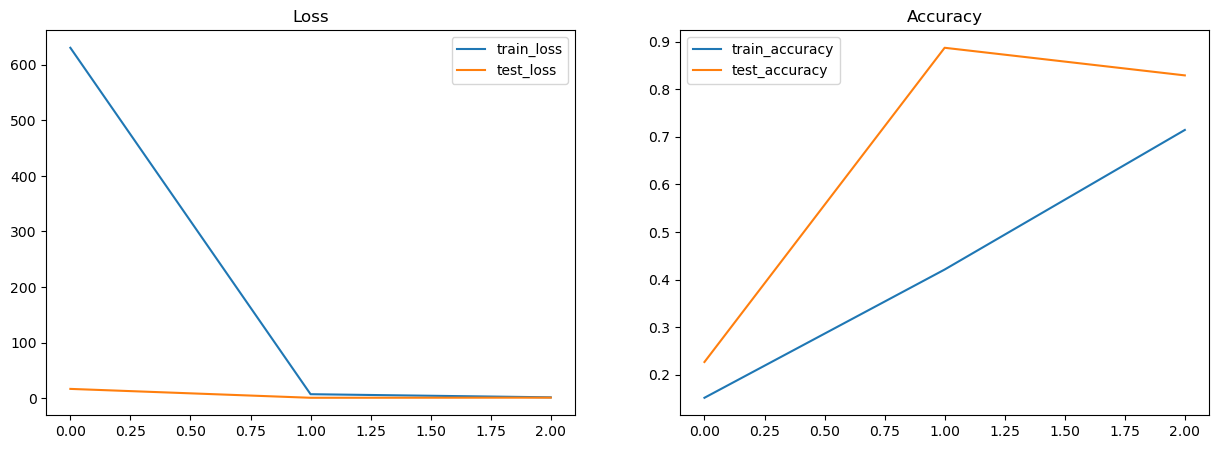

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [21]:
utils.save_thing(state.opt_state, "opt_state.pkl")
utils.save_thing(state.params, "params.pkl")
utils.save_thing(metrics_history, "metrics_history.pkl")
